# 02. Neural Network classification with PyTorch

Classification is a problem whether something is one thing or another (there can be multiple things as the options.)

In [1]:
## 1. Make Classification data and get it ready

In [2]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

#create circles

X,Y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [3]:
len(X) , len(Y)

(1000, 1000)

In [4]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [5]:
Y[:5]

array([1, 1, 1, 1, 0], dtype=int64)

In [6]:
# Make Dataframe of circle data
import pandas as pd

circle = pd.DataFrame({"X1":X[:,0],
                       "X2":X[:,1],
                       "Labels":Y})

In [7]:
circle.head()

,X1,X2,Labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


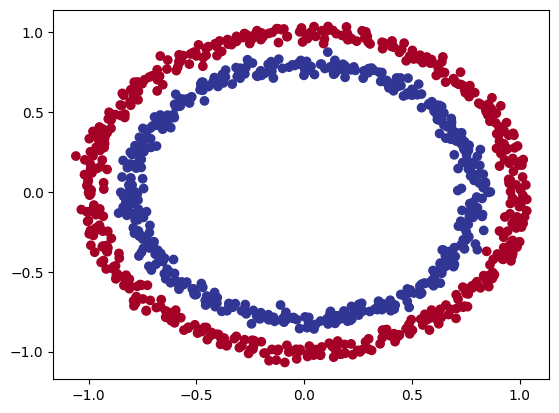

In [8]:
# Visualize 

import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=Y,
            cmap=plt.cm.RdYlBu);

**Note:** The data we are working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

# 1.1 Check input and output shapes

In [9]:
X.shape,Y.shape

((1000, 2), (1000,))

In [10]:
# View the first example of feature and labels
X_sample = X[0]
Y_sample = Y[0]

print(f"x and y samples{X_sample}  {Y_sample}")
print(f"x and y samples shape {X_sample.shape}  {Y_sample.shape}")


x and y samples[0.75424625 0.23148074]  1
x and y samples shape (2,)  ()


# 1.2 Turning data into tensors and create train and test splits 

In [11]:
import torch
type(X)

numpy.ndarray

In [12]:
# Turn data into tensors 
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

In [13]:
type(X)
type(Y)

torch.Tensor

In [14]:
## Split the data into into test and training 

from sklearn.model_selection import train_test_split

X_train , X_test , Y_train , Y_test = train_test_split(X,
                                                       Y,
                                                       test_size=0.2,
                                                       random_state=42) 

In [15]:
len(X_train) , len(X_test)

(800, 200)

## 2. Building the Model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonist code so our code will run on GPU
2. Construct a model (by sub-classing the nn.Module)
3. Define a loss function and optimizer 
4. Create a training and testing loop


In [16]:
from torch import nn

#Make Device agnostic code

device = "cuda" if torch.cuda.is_available() else "CPU"
device

'cuda'

Now
1. Sub-classing 'nn.Module' (almost all models in PyTorch subclass 'nn.Module')
2. Create 2 'nn.Linear()' layers that are capable of handling the shapes of our data
3. Define a 'forward()' method that outline the forward pass
4. setup an instance od our model class and send it to the target device

In [17]:
# step 1

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        ## step 2
        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5,out_features=1) 


    def forward(self,X):
        return self.layer_2(self.layer_1(X)) # X >> layer1 >> layer 2 >> output        

In [18]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
next(model_0.parameters()).device

device(type='cuda', index=0)

Using nn.Sequential()

In [20]:
class CircleModelV01(nn.Module):
    def __init__(self):
        super().__init__()

        self.two_liner_layer = nn.Sequential(
            nn.Linear(in_features=2,out_features=5),
            nn.Linear(in_features=5,out_features=1)
            )
        
    def forward(self,X):
        return self.two_liner_layer(X)


model_01 = CircleModelV01().to(device)          

In [21]:
next(model_01.parameters()).device

device(type='cuda', index=0)

In [22]:
model_01.state_dict()

OrderedDict([('two_liner_layer.0.weight',
              tensor([[-0.5464,  0.1471],
                      [ 0.6221, -0.2859],
                      [-0.3958,  0.0018],
                      [ 0.7033, -0.6192],
                      [ 0.3964,  0.6326]], device='cuda:0')),
             ('two_liner_layer.0.bias',
              tensor([ 0.0233, -0.3425, -0.6712, -0.2134, -0.0910], device='cuda:0')),
             ('two_liner_layer.1.weight',
              tensor([[-0.3083, -0.1999, -0.3957,  0.2228, -0.1965]], device='cuda:0')),
             ('two_liner_layer.1.bias', tensor([-0.0008], device='cuda:0'))])

In [23]:
## 2.1 Setting up loss and optimizer

#Which loss function and optimizer should we use ?


## For regression you might want MAE or MSE .

## For classification you might want binary cross entropy or categorical cross entropy

In [24]:
# loss function
# loss_fun = nn.BCELoss() # BCELoss requires input to have gone through the sigmoid activation function prior to input to BCELoss
loss_fun = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function build-in

# Optimizer
optimizer = torch.optim.SGD(params=model_01.parameters(),
                            lr=0.1)

In [25]:
## Calculate accuracy - out of 100 examples, what percentage does our model get right ?

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100

    return acc


# 3. Trining the model
To train the model we are going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward(back-propagation)
5. Optimizer step(gradient descent) 

# 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function(ex. sigmoid for binary classification and softmax for multi-class classification).
<br>

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the argmax().

In [26]:
model_01

CircleModelV01(
  (two_liner_layer): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [27]:
# View the first 5 outputs of the forward pass on the test data
model_01.eval()

with torch.inference_mode():
    y_logits = model_01(X_test.to(device))[:5]
y_logits    

tensor([[ 0.0201],
        [ 0.0596],
        [ 0.1790],
        [-0.0260],
        [ 0.5957]], device='cuda:0')

In [28]:
# Use the sigmoid activation function on our model logits to turn them into predictoins prob.
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5050],
        [0.5149],
        [0.5446],
        [0.4935],
        [0.6447]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* 'y_pred_probs' >= 0.5 , 'y=1' (class 1)
* 'y_pred_probs' < 0.5 , 'y=0' (class 0)

In [29]:
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

In [30]:
# Find the predicted labels 
y_preds = torch.round(y_pred_probs)


# in full

y_pred_labels = torch.round(torch.sigmoid(model_01(X_test.to(device))[:5]))

# check for equality 
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

# Get rid of extra dimension

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 0., 1.], device='cuda:0')

If we are doing prediction with raw logits we need to use activation function

In [31]:
### 3.2 Building Training and testing loop


In [32]:
torch.cuda.manual_seed(42)

# Set epochs

epochs = 1000

#Put data to target device 
X_train , Y_train = X_train.to(device) , Y_train.to(device)
X_test , Y_test = X_test.to(device) , Y_test.to(device)

# Build trining and evaluation loop

for epoch in range(epochs):
    model_01.train()

    # 1. Forward pass
    y_logits = model_01(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))# turn logits -> pred probs -> pred labels
    # use y_pred if loss function in not taking logits

    # loss = loss_fun(torch.sigmoid(y_logits),
    #                 Y_train) use this for nn.BCELoss
    # 2. Calculate loss/accuracy
    loss = loss_fun(y_logits,     # nn.BCEWithLogitsLoss expects raw logits as input
                    Y_train)
    
    acc = accuracy_fn(y_true=Y_train,
                      y_pred=y_pred)
    

    # 3.Optimizer 
    optimizer.zero_grad()

    # 4. loss backward

    loss.backward()

    # 5. optimizer step

    optimizer.step()


    # Testing
    model_01.eval()

    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_01(X_test).squeeze()

        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss

        test_loss = loss_fun(test_logits,Y_test)

        test_acc = accuracy_fn(y_true=Y_test,
                               y_pred=test_pred)
        

    if epoch % 10 ==0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f}, Acc: {acc:.2f} | Test loss {test_loss: .5f},Test acc: {test_acc:.2f}%")      
    

Epoch: 0 | Loss:  0.71227, Acc: 57.38 | Test loss  0.70602,Test acc: 60.00%
Epoch: 10 | Loss:  0.70346, Acc: 52.62 | Test loss  0.69902,Test acc: 56.50%
Epoch: 20 | Loss:  0.69931, Acc: 51.12 | Test loss  0.69592,Test acc: 56.00%
Epoch: 30 | Loss:  0.69709, Acc: 50.50 | Test loss  0.69441,Test acc: 55.00%
Epoch: 40 | Loss:  0.69579, Acc: 50.62 | Test loss  0.69362,Test acc: 52.50%
Epoch: 50 | Loss:  0.69497, Acc: 50.75 | Test loss  0.69321,Test acc: 51.00%
Epoch: 60 | Loss:  0.69442, Acc: 51.00 | Test loss  0.69300,Test acc: 50.00%
Epoch: 70 | Loss:  0.69405, Acc: 51.12 | Test loss  0.69291,Test acc: 49.50%
Epoch: 80 | Loss:  0.69378, Acc: 51.12 | Test loss  0.69289,Test acc: 49.00%
Epoch: 90 | Loss:  0.69359, Acc: 50.50 | Test loss  0.69292,Test acc: 50.50%
Epoch: 100 | Loss:  0.69345, Acc: 50.50 | Test loss  0.69298,Test acc: 51.50%
Epoch: 110 | Loss:  0.69335, Acc: 50.12 | Test loss  0.69306,Test acc: 53.00%
Epoch: 120 | Loss:  0.69327, Acc: 49.75 | Test loss  0.69314,Test acc: 53.5

# 4. Make Prediction and evaluate the model

From the metrics it look like our model isn't learning anything 
<br>
So to inspect it let's make some predictions and make them visual
<br>
To do we are going to import a function called 'plot_decision_boundary()'

In [33]:
import requests
from pathlib import Path
if Path("helper_function.py").is_file():
    print("already exist")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

Downloading


In [34]:
from helper_functions import plot_predictions , plot_decision_boundary

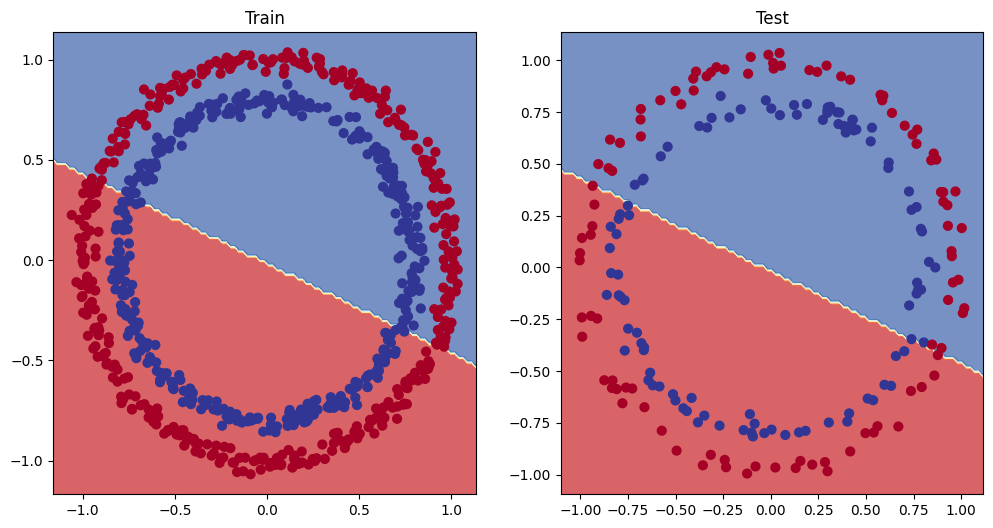

In [35]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_01,X_train,Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_01,X_test,Y_test)

# 5.Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units- from 5 hidden units to 10 hidden units
* Fit for longer 
* Changing the activation functions
* Changing learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model,rather than the data.
<br>

And because these options are all values we can change they are referred as **hyperparameters**

In [36]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3035,  0.0842],
                      [ 0.0804, -0.1438],
                      [-0.2707,  0.0896],
                      [-0.1529,  0.3743],
                      [ 0.6857, -0.4571]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.1181,  0.0207, -0.1890,  0.3633, -0.4047], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.3968,  0.0185, -0.0426,  0.3748, -0.4152]], device='cuda:0')),
             ('layer_2.bias', tensor([0.0384], device='cuda:0'))])

In [76]:
## Adding hidden units

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10 , out_features=1)

    def forward(self,X):
        z = self.layer_1(X)
        z = self.layer_2(z)
        z = self.layer_3(z)

        # return z # we can use this return also if we need
    
        return z   
    

model_1 = CircleModelV1().to(device)
model_1    

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [77]:
model_1 = CircleModelV1().to(device)
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimize 
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [78]:
# write training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    model_1.train()

    y_logits1 = model_1(X_train).squeeze()
    y_pred1 = torch.round(torch.sigmoid(y_logits1))

    loss = loss_fn(y_logits1,Y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    acc = accuracy_fn(y_true=Y_train,
                      y_pred=y_pred1)


    ## Testing
    model_1.eval()
    with torch.inference_mode():
        test_logits1 = model_1(X_test).squeeze()
        test_pred1 = torch.round(torch.sigmoid(test_logits1))

        test_loss1 = loss_fn(test_logits1,Y_test)

        test_acc1 = accuracy_fn(y_true=Y_test,
                                y_pred=test_pred1)
        

    if epoch % 100 ==0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f}, Acc: {acc:.2f} | Test loss {test_loss1: .5f},Test acc: {test_acc1:.2f}%")     


        
    

Epoch: 0 | Loss:  0.69528, Acc: 51.38 | Test loss  0.69252,Test acc: 50.50%
Epoch: 100 | Loss:  0.69325, Acc: 47.88 | Test loss  0.69283,Test acc: 51.00%
Epoch: 200 | Loss:  0.69309, Acc: 49.88 | Test loss  0.69344,Test acc: 46.50%
Epoch: 300 | Loss:  0.69303, Acc: 50.50 | Test loss  0.69384,Test acc: 47.50%
Epoch: 400 | Loss:  0.69300, Acc: 51.38 | Test loss  0.69412,Test acc: 46.50%
Epoch: 500 | Loss:  0.69299, Acc: 51.12 | Test loss  0.69431,Test acc: 46.00%
Epoch: 600 | Loss:  0.69298, Acc: 51.50 | Test loss  0.69444,Test acc: 46.00%
Epoch: 700 | Loss:  0.69298, Acc: 51.38 | Test loss  0.69452,Test acc: 45.50%
Epoch: 800 | Loss:  0.69298, Acc: 51.50 | Test loss  0.69458,Test acc: 44.50%
Epoch: 900 | Loss:  0.69298, Acc: 51.38 | Test loss  0.69461,Test acc: 45.00%


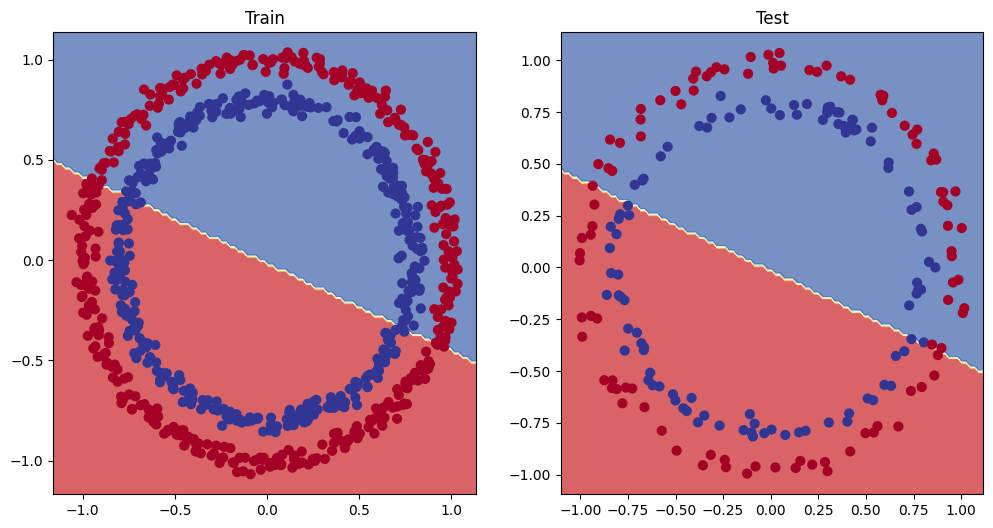

In [79]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train,Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test,Y_test)

# 5.1 Preparing data to see if our model can fit a straight line 

One way to troubleshoot to a large problem is to test out a smaller problem

In [80]:
# Create some data 

weight = 0.7
bias =0.3 
start = 0 
end = 1
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
Y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5],Y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [81]:
# Create split
train_split = int(0.8*len(X_regression))

X_train_regression,Y_train_regression = X_regression[:train_split] , Y_regression[:train_split]
X_test_regression,Y_test_regression = X_regression[train_split:] , Y_regression[train_split:]

len(X_train_regression),len(Y_train_regression) , len(X_test_regression) , len(Y_test_regression)

(80, 80, 20, 20)

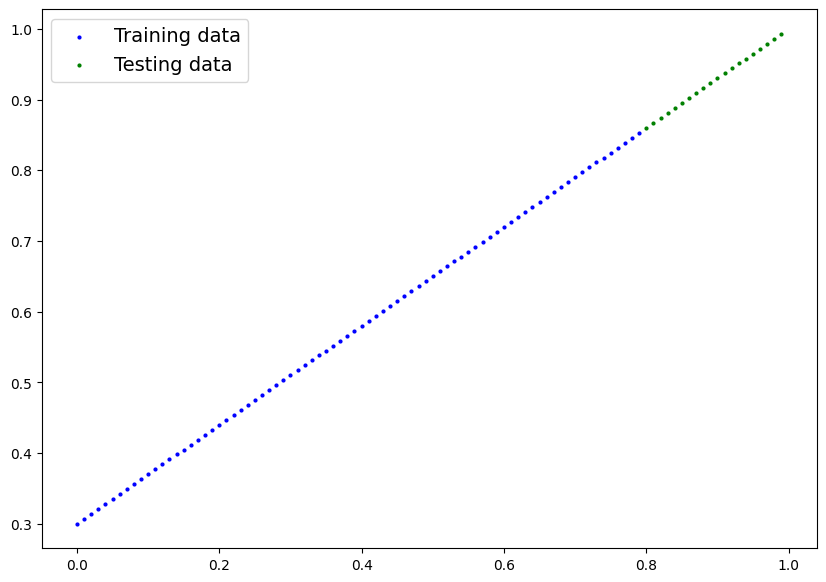

In [82]:
plot_predictions(train_data=X_train_regression,
                 train_labels=Y_train_regression,
                 test_data=X_test_regression,
                 test_labels=Y_test_regression)

# 5.2 Adjusting 'model_1' to fit a straight line


In [83]:
# Same architecture as model_1 (but using nn.sequential())

model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
    ).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [86]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr = 0.01)

In [87]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression,Y_train_regression = X_train_regression.to(device) , Y_train_regression.to(device)
X_test_regression,Y_test_regression = X_test_regression.to(device) , Y_test_regression.to(device)


for epoch in range(epochs):
    model_2.train()

    y_pred = model_2(X_train_regression)

    loss = loss_fn(y_pred,Y_train_regression)


    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    #Test
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred,Y_test_regression)

    if epoch % 100 == 0:
        print(f"Epoch:{epoch} | Loss:{loss:.5f} | Test loss: {test_loss:.5f}")     

    

Epoch:0 | Loss:0.06466 | Test loss: 0.12597
Epoch:100 | Loss:0.00743 | Test loss: 0.00093
Epoch:200 | Loss:0.00621 | Test loss: 0.00123
Epoch:300 | Loss:0.00619 | Test loss: 0.00116
Epoch:400 | Loss:0.00617 | Test loss: 0.00094
Epoch:500 | Loss:0.00646 | Test loss: 0.00138
Epoch:600 | Loss:0.00614 | Test loss: 0.00110
Epoch:700 | Loss:0.00612 | Test loss: 0.00103
Epoch:800 | Loss:0.00641 | Test loss: 0.00149
Epoch:900 | Loss:0.00639 | Test loss: 0.00118


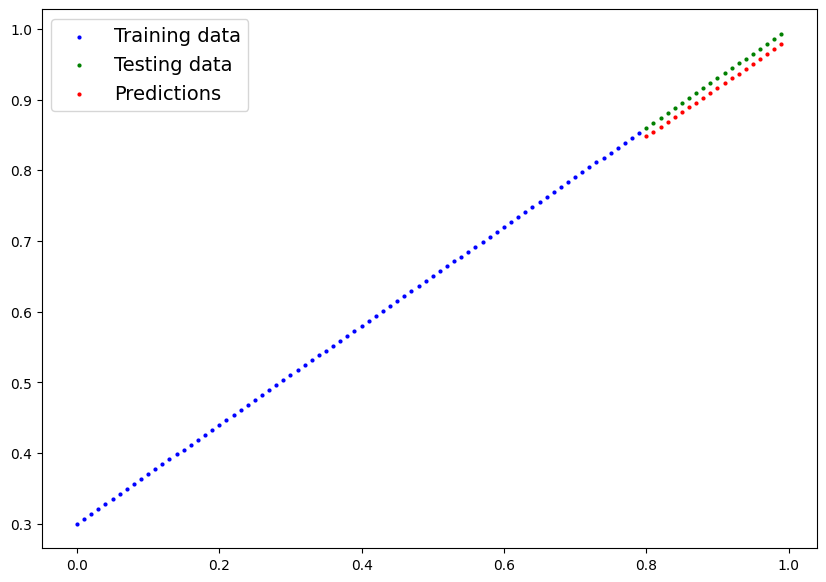

In [93]:
# Turn on evaluation
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)


plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=Y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=Y_test_regression.cpu(),
                 predictions=y_preds.cpu())    